# Evaluate forecasts

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
DATADIR = '/data/weather-benchmark/5.625deg/'
PREDDIR = '/data/weather-benchmark/predictions/'

## Load data

In [5]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid_data = xr.merge([z500_valid, t850_valid])

In [6]:
persistence = xr.open_dataset(f'{PREDDIR}persistence.nc').drop('level')
climatology = xr.open_dataset(f'{PREDDIR}climatology.nc')
weekly_climatology = xr.open_dataset(f'{PREDDIR}weekly_climatology.nc')

In [7]:
lr_3d = xr.open_dataset(f'{PREDDIR}fc_lr_3d.nc')
lr_5d = xr.open_dataset(f'{PREDDIR}fc_lr_5d.nc')
lr_6h_iter = xr.open_dataset(f'{PREDDIR}fc_lr_6h_iter.nc')

In [28]:
# See next section on how to compute these from the raw data.
tigge = xr.open_dataset(f'{PREDDIR}/tigge_5.625deg.nc')
t21 = xr.open_dataset(f'{PREDDIR}/t21_5.625deg.nc')

## TIGGE and IFT T21 data

For these we need to do some preprocessing to get the data into the same format as our ERA5 files.

In [8]:
# Convert from geopotential height to geopotential
tigge_raw = xr.open_mfdataset('/data/weather-benchmark/tigge/5.625deg/*').squeeze()

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along the dimensions None. Alternati

In [9]:
tigge_raw['z'] = tigge_raw.gh * 9.807
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 12768)
Coordinates:
    lev      float64 5e+04
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-11-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    z        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.4
    history:      Tue Dec 03 13:14:18 2019: cdo -f nc copy /data/weather-benc...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...

In [10]:
t21_raw = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/IFS_T21/raw/output_pl_5.625*.nc')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [11]:
t21_raw

<xarray.Dataset>
Dimensions:  (lat: 32, lev: 4, lon: 64, time: 42340)
Coordinates:
  * lev      (lev) float64 1e+05 8.5e+04 5e+04 2e+04
  * lat      (lat) float64 87.19 81.56 75.94 70.31 ... -75.94 -81.56 -87.19
  * lon      (lon) float64 -180.0 -174.4 -168.8 -163.1 ... 163.1 168.8 174.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-01-07T18:00:00
Data variables:
    z        (time, lev, lat, lon) float32 dask.array<chunksize=(20996, 4, 32, 64), meta=np.ndarray>
    t        (time, lev, lat, lon) float32 dask.array<chunksize=(20996, 4, 32, 64), meta=np.ndarray>
    r        (time, lev, lat, lon) float32 dask.array<chunksize=(20996, 4, 32, 64), meta=np.ndarray>
    u        (time, lev, lat, lon) float32 dask.array<chunksize=(20996, 4, 32, 64), meta=np.ndarray>
    v        (time, lev, lat, lon) float32 dask.array<chunksize=(20996, 4, 32, 64), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.4
    

In [12]:
t21_raw['lat'] = -tigge_raw.lat
t21_raw = t21_raw.roll(lon=32)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


In [13]:
def convert_time(ds, nlead_time):
    """Converts to lead_time format"""
    init_times = ds.time[::nlead_time]
    lead_times = xr.DataArray(
        np.arange(0, 6*nlead_time, 6), dims=['lead_time'], coords={'lead_time': np.arange(0, 6*nlead_time, 6)})
    
    coords = dict(ds.coords); coords.pop('time')
    coords['time'] = init_times; coords['lead_times'] = lead_times
    ds_by_lead = xr.merge([xr.DataArray(
        ds[var].values.reshape((len(init_times), len(lead_times)) + ds[var].shape[1:]),
        dims = ('time', 'lead_time') + ds[var].dims[1:],
        coords = coords,
        name=var
    ) for var in ds])
    return ds_by_lead

In [14]:
tigge = convert_time(tigge_raw, 21)
t21 = convert_time(t21_raw, 29)

In [15]:
# Save for later usage
tigge.to_netcdf(f'{PREDDIR}/tigge_5.625deg.nc')
t21.to_netcdf(f'{PREDDIR}/t21_5.625deg.nc')

## Compute RMSE

In [17]:
tigge = tigge.merge(evaluate_iterative_forecast(tigge, valid_data)).load()
t21 = t21.merge(evaluate_iterative_forecast(t21, valid_data)).load()


In [18]:
persistence = persistence.merge(evaluate_iterative_forecast(persistence, valid_data)).load()
climatology = climatology.merge(compute_weighted_rmse(climatology, valid_data)).load()
weekly_climatology = weekly_climatology.merge(compute_weighted_rmse(weekly_climatology, valid_data)).load()

In [19]:
lr_6h_iter = lr_6h_iter.merge(evaluate_iterative_forecast(lr_6h_iter, valid_data)).load()
lr_3d = lr_3d.merge(compute_weighted_rmse(lr_3d, valid_data)).load()
lr_5d = lr_5d.merge(compute_weighted_rmse(lr_5d, valid_data)).load()

## Plot

In [24]:
def create_plot(var):
    # Color settings
    c_lr = 'seagreen'
    c_cnn = 'firebrick'
    c_tigge = 'navy'
    c_t21 = 'orange'
    c_persistence = '0.2'
    c_climatology = '0.5'
    c_weekly_climatology = '0.7'
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    tigge[var+'_rmse'].plot(c=c_tigge, label='Operational', lw=2)
    t21[var+'_rmse'].plot(c=c_t21, label='IFS T21', lw=2)
    lr_6h_iter[var+'_rmse'].plot(c=c_lr, label='Linear regression', lw=2)
    persistence[var+'_rmse'].plot(c=c_persistence, label='Persistence', lw=2)
    ax.axhline(climatology[var+'_rmse'], ls='--', c=c_climatology, label='Climatology', lw=2)
    ax.axhline(weekly_climatology[var+'_rmse'], ls='--', c=c_weekly_climatology, label='Weekly climatology', lw=2)
    
    plt.scatter([3*24], [lr_3d[var+'_rmse']], c=c_lr, s=75)
    plt.scatter([5*24], [lr_5d[var+'_rmse']], c=c_lr, s=75)
    
    plt.legend(loc=2, framealpha=1)
    plt.xlim(0, 122)
    plt.xticks(range(0, 121, 24), range(0, 6))
    plt.xlabel('Forecast lead time [days]')
    
    if var == 'z':
        plt.ylim(0, 1150)
        plt.ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
    elif var == 't':
        plt.ylim(0, 7)
        plt.ylabel(r'T850 RMSE [K]')

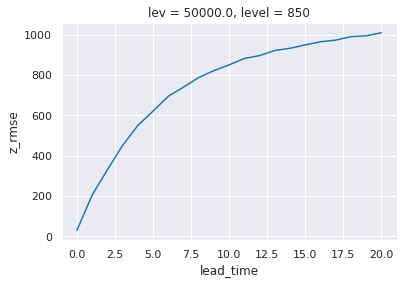

In [28]:
tigge.z_rmse.plot()

In [27]:
t21.z_rmse.values

array([46392.21552643, 46378.93679903, 46366.9607889 , 46359.72505494,
       46355.05970175, 46352.99108315, 46351.53169174, 46351.53385892,
       46351.8870864 , 46352.85681904, 46353.81114561, 46354.40003799,
       46354.36386576, 46354.01769648, 46353.43131118, 46352.95975729,
       46352.39376263, 46351.29035974, 46349.89982381, 46348.38358521,
       46347.10875513, 46345.79692968, 46344.44140218, 46342.62019692,
       46340.81843464, 46339.29701697, 46337.7524336 , 46336.2138523 ,
       46335.22130519])

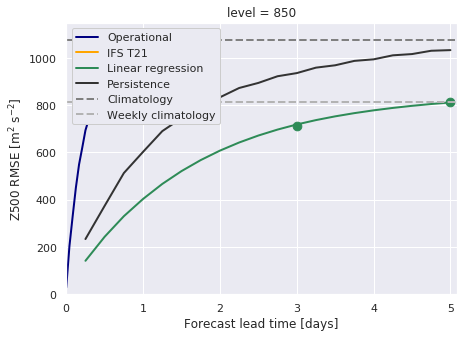

In [26]:
create_plot('z')

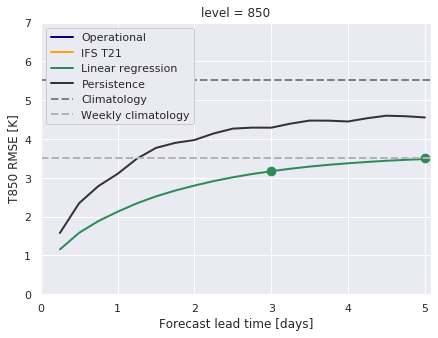

In [29]:
create_plot('t')